# Manoeuvring simulations

## Purpose
* The regression of simulated data works extremly well with linear data as seen in: [12.01_regression_simulated_data.ipynb](12.01_regression_simulated_data.ipynb)
* Will this also work when adding nonlinear terms to the EOM and system force model?

## Methodology
* Simulate wPCC using Brix coefficients.
* Regress the simulated data
* What is the accuray?
* Are the coefficients the same?

## Results
Describe and comment the most important results.

## Setup

In [1]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot
from src.equation import Equation

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_nonlinear_EOM  as vmm

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Ship parameters

In [22]:
T_ = 5
L_ = 100
rho_ = 1000
B_ = 20
CB_ = 0.65
Volume_ = L_*B_*T_*CB_
m_ = Volume_*rho_
x_G_ = 1.5
I_z_ = m_*(L_*0.2)**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : x_G_,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':Volume_,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

In [23]:
ship_parameters

{'T': 5,
 'L': 100,
 'CB': 0.65,
 'B': 20,
 'rho': 1000,
 'x_G': 1.5,
 'm': 6500000.0,
 'I_z': 2600000000.0,
 'volume': 6500.0}

In [24]:
ship_parameters_prime = ps.prime(ship_parameters)

## Brix parameters

In [25]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

#df_parameters['brix_prime'].fillna(0, inplace=True)


In [26]:
df_parameters['prime'] = df_parameters['brix_prime']

df_parameters.loc['Ydelta','prime'] = 0.001  # Just guessing
df_parameters.loc['Ndelta','prime'] = -df_parameters.loc['Ydelta','prime']/2  # Just guessing
df_parameters['prime'].fillna(0, inplace=True)

In [38]:
mask = df_parameters['prime'].abs() > 0
for index, parameter in df_parameters.loc[mask].iterrows():
    display(sp.Eq(parameter['symbol'],parameter['prime']))

Eq(X_{\dot{u}}, 0.000520694375159361)

Eq(Y_{\dot{v}}, -0.00951902574037707)

Eq(Y_{\dot{r}}, -0.000637743308678728)

Eq(N_{\dot{v}}, -0.000471238898038469)

Eq(N_{\dot{r}}, -0.00048328166987723)

Eq(Y_{v}, -0.0160221225333079)

Eq(Y_{r}, 0.0029845130209103)

Eq(Y_{delta}, 0.001)

Eq(N_{v}, -0.00486946861306418)

Eq(N_{r}, -0.0023090706003885)

Eq(N_{delta}, -0.0005)

## Simulate data

In [27]:
parameters=df_parameters['prime'].copy()

t_ = np.linspace(0,400,1000)
df = pd.DataFrame(index=t_)

df['u'] = 2
df['v'] = 0
df['r'] = 0
df['x0'] = 0
df['y0'] = 0
df['psi'] = 0
df['U'] = np.sqrt(df['u']**2 + df['v']**2)
df['beta'] = -np.arctan2(df['v'],df['u'])

df['delta'] = np.deg2rad(20)

result = vmm.simulator.simulate(df_=df, parameters=parameters, ship_parameters=ship_parameters, 
                                  control_keys=['delta'], primed_parameters=True,prime_system=ps)

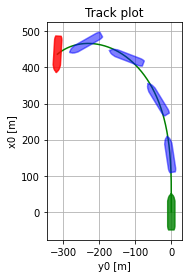

In [28]:
result.track_plot();

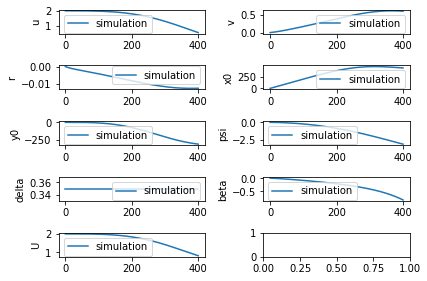

In [43]:
result.plot()